In [4]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import albumentations as A
from classname import class_names
from Visualize_data import visualize_image_and_label, visualize_random_images


In [97]:
#count the number of images in the data directory
def count_images(data_dir):
    images = [f for f in os.listdir(data_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    return len(images)

data_dir_train = 'data_aug/train/images'
data_dir_test = 'data_aug/test/images'
data_dir_val = 'data_aug/valid/images'
print(f'train: {count_images(data_dir_train)}')
print(f'test: {count_images(data_dir_test)}')
print(f'valid: {count_images(data_dir_val)}')


train: 6544
test: 231
valid: 491


train: 1,636
test: 231
vail: 491

train 7,
test 1,
valid 2,
total 10


Augmentation Train


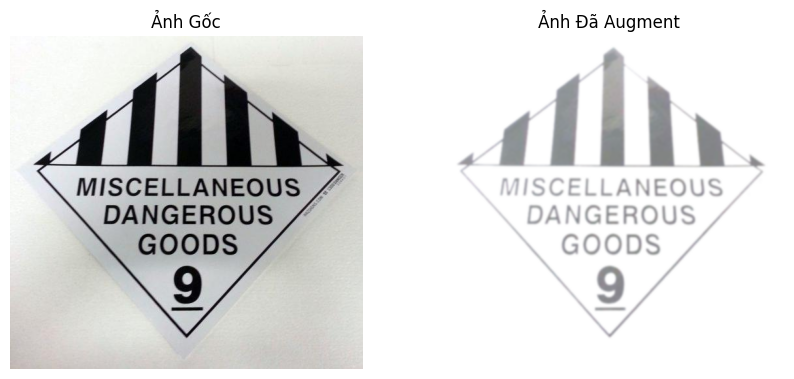

In [98]:
#ban đêm
# transform = A.Compose([
#     A.RandomBrightnessContrast(brightness_limit=(-0.3, -0.3), contrast_limit=(-0.2, -0.2), p=1), 
#     A.GaussianBlur(blur_limit=(3, 7), p=1), 
#     A.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=-50, val_shift_limit=-30, p=1),  
# ])

#trời nắng to
transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(0.4, 0.6), contrast_limit=(0.3, 0.5), p=1), 
    A.GaussianBlur(blur_limit=(3, 7), p=1), 
])

image = cv2.imread("Hazmat Placards.v1i.yolov11/train/images/0c93c378e8_jpg.rf.adb3ef1a8039aff9909d9bd00101e18c.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

transformed = transform(image=image)
transformed_image = transformed["image"]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Ảnh Gốc')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(transformed_image)
plt.title('Ảnh Đã Augment')
plt.axis('off')

plt.show()

Visualize data augmentation

['29 0.18052951388888894 0.6796178733549891 0.0694878472222222 0.126518771864068\n', '29 0.8305230034722222 0.5211586914875895 0.026245659722222148 0.07280214059636853\n']


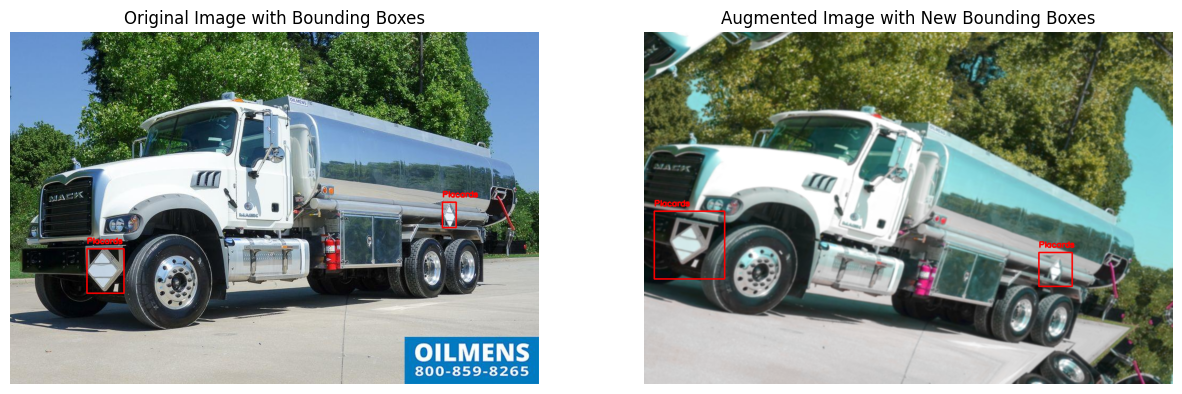

Original bounding boxes: [[0.18052951388888894, 0.6796178733549891, 0.0694878472222222, 0.126518771864068], [0.8305230034722222, 0.5211586914875895, 0.026245659722222148, 0.07280214059636853]]
Augmented bounding boxes: [[0.08576300740242004, 0.6070504188537598, 0.13340061902999878, 0.19214515388011932], [0.7783863544464111, 0.6756376624107361, 0.06281255930662155, 0.09587967395782471]]
Class Labels: ['Placards', 'Placards']


In [4]:
def clip_bboxes(bbox, min_value=0, max_value=1):
    return [max(min(coord, max_value), min_value) for coord in bbox]

transform = A.Compose([
    A.HorizontalFlip(p=0.6),
    A.RandomBrightnessContrast(p=0.6),
    A.Rotate(limit=40, p=0.8),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=1),
    A.GaussianBlur(blur_limit=(3, 7), p=1),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

image = cv2.imread('datatest/train/images/0f8b2f5253cfefa7e479d6d25156b4fc_jpg.rf.ac741e8aefcf90f2341faefb2c62aa24.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

with open('datatest/train/labels/0f8b2f5253cfefa7e479d6d25156b4fc_jpg.rf.ac741e8aefcf90f2341faefb2c62aa24.txt', 'r') as f:
    lines = f.readlines()

print(lines)

bboxes = []
class_labels = []

for line in lines:
    values = line.strip().split()[:5]  
    class_id, x_center, y_center, bbox_width, bbox_height = map(float, values)
    
    bboxes.append([x_center, y_center, bbox_width, bbox_height])
    class_labels.append(class_names[int(class_id)])


bboxes = [clip_bboxes(bbox) for bbox in bboxes]

augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
augmented_image = augmented['image']
augmented_bboxes = [clip_bboxes(bbox) for bbox in augmented['bboxes']]

def draw_bboxes(image, bboxes, class_labels=None):
    for i, bbox in enumerate(bboxes):
        x_center, y_center, bbox_width, bbox_height = bbox
        x1 = int((x_center - bbox_width / 2) * image.shape[1])
        y1 = int((y_center - bbox_height / 2) * image.shape[0])
        x2 = int((x_center + bbox_width / 2) * image.shape[1])
        y2 = int((y_center + bbox_height / 2) * image.shape[0])
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        if class_labels and i < len(class_labels):
            cv2.putText(image, class_labels[i], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

original_image_with_bbox = image.copy()
draw_bboxes(original_image_with_bbox, bboxes, class_labels)

augmented_image_with_bbox = augmented_image.copy()
draw_bboxes(augmented_image_with_bbox, augmented_bboxes, augmented['class_labels'])

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(original_image_with_bbox)
plt.title('Original Image with Bounding Boxes')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(augmented_image_with_bbox)
plt.title('Augmented Image with New Bounding Boxes')
plt.axis('off')

plt.show()

print("Original bounding boxes:", bboxes)
print("Augmented bounding boxes:", augmented_bboxes)
print("Class Labels:", class_labels)


Augmentation 

In [83]:
source_image_folder = 'Hazmat Placards.v1i.yolov11/train/images'
source_label_folder = 'Hazmat Placards.v1i.yolov11/train/labels'
aug_image_folder = 'data_aug/train/images'
aug_label_folder = 'data_aug/train/labels'

os.makedirs(aug_image_folder, exist_ok=True)
os.makedirs(aug_label_folder, exist_ok=True)

def clip_bboxes(bbox, min_value=0, max_value=1):
    return [max(min(coord, max_value), min_value) for coord in bbox]

transform = A.Compose([
    A.HorizontalFlip(p=1),
    A.RandomBrightnessContrast(p=1),
    A.Rotate(limit=40, p=1),
    # A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, p=1),
    A.GaussianBlur(blur_limit=(3, 7), p=1),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

for image_filename in os.listdir(source_image_folder):
    if image_filename.endswith('.jpg') or image_filename.endswith('.png'):  
        try:
            image_path = os.path.join(source_image_folder, image_filename)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Unable to read image {image_filename}. Skipping.")
                continue  
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

            label_filename = image_filename.replace('.jpg', '.txt').replace('.png', '.txt')
            label_path = os.path.join(source_label_folder, label_filename)

            bboxes = []
            class_labels = []

            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                values = line.strip().split() 
                class_id, x_center, y_center, bbox_width, bbox_height = map(float, values)

                bboxes.append([x_center, y_center, bbox_width, bbox_height])
                class_labels.append(int(class_id))  

            bboxes = [clip_bboxes(bbox) for bbox in bboxes]

            augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
            augmented_image = augmented['image']
            augmented_bboxes = [clip_bboxes(bbox) for bbox in augmented['bboxes']]
            
            original_output_path = os.path.join(aug_image_folder, image_filename)
            cv2.imwrite(original_output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))  

            augmented_image_path = os.path.join(aug_image_folder, f'aug_{image_filename}')  
            cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

            original_label_path = os.path.join(aug_label_folder, label_filename)
            with open(original_label_path, 'w') as f:
                for bbox, class_id in zip(bboxes, class_labels):
                    f.write(f"{class_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")


            augmented_label_path = os.path.join(aug_label_folder, f'aug_{label_filename}') 
            with open(augmented_label_path, 'w') as f:
                for bbox, class_id in zip(augmented_bboxes, class_labels):
                    f.write(f"{class_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

        except Exception as e:
            print(f"Error processing {image_filename}: {e}. Skipping.")

print("Augmentation completed and images and labels are saved.")


Augmentation completed and images and labels are saved.


c:\Users\Admin\anaconda3\envs\hazardous_detection\lib\site-packages\albumentations\core\composition.py:192: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


Check label data

['10', '0.4345000088214874', '0.7275000214576721', '0.11500000953674316', '0.11899995803833008']
Class ID: 10, Class Name: 2-3 Toxic gases
['20', '0.49449998140335083', '0.22450000047683716', '0.132999986410141', '0.11100000143051147']
Class ID: 20, Class Name: 6 Poisons
['10', '0.8149999976158142', '0.4865000247955322', '0.14600002765655518', '0.13500002026557922']
Class ID: 10, Class Name: 2-3 Toxic gases
['10', '0.03550000116229057', '0.34450000524520874', '0.07100000232458115', '0.11500000953674316']
Class ID: 10, Class Name: 2-3 Toxic gases


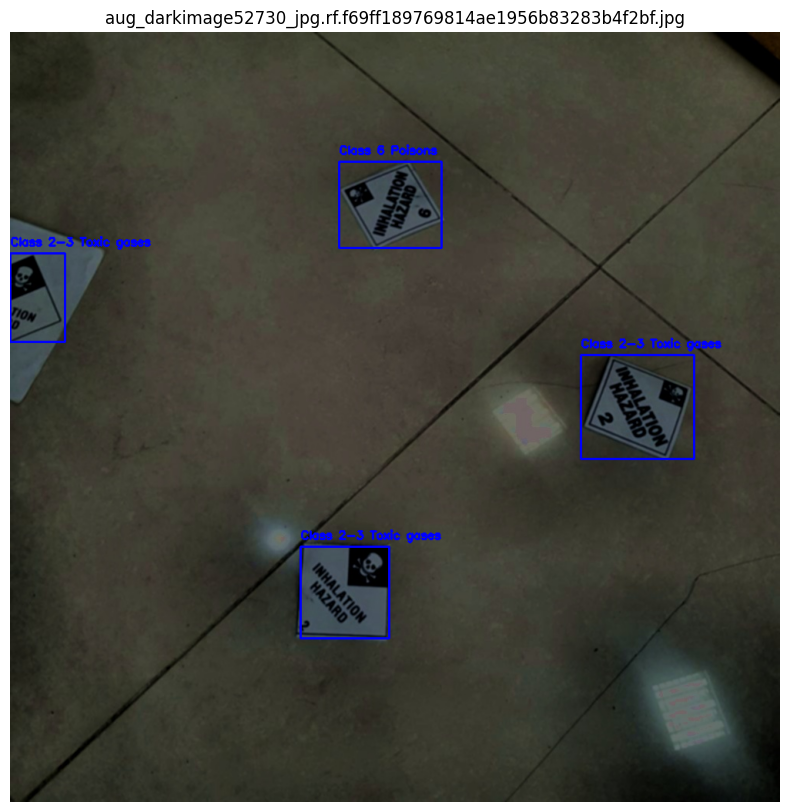

['14', '0.40914', '0.47366', '0.5449400000000001', '0.554']
Class ID: 14, Class Name: 3 Flammable liquid


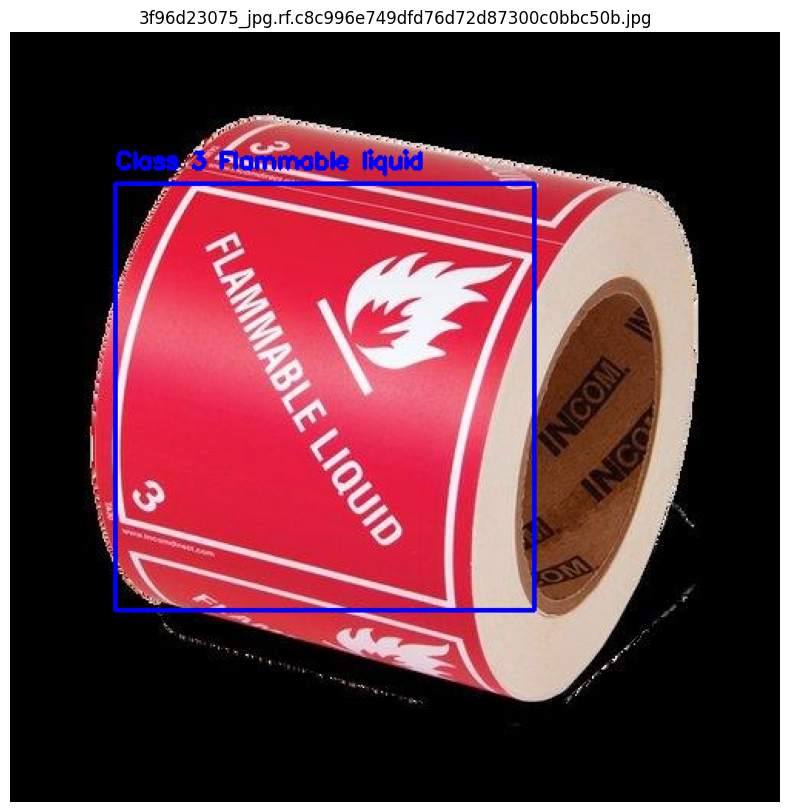

['18', '0.634375', '0.59375', '0.146875', '0.18125']
Class ID: 18, Class Name: 5-1 Oxidizing substances
['7', '0.88125', '0.6734375', '0.115625', '0.14375']
Class ID: 7, Class Name: 2 Oxygen


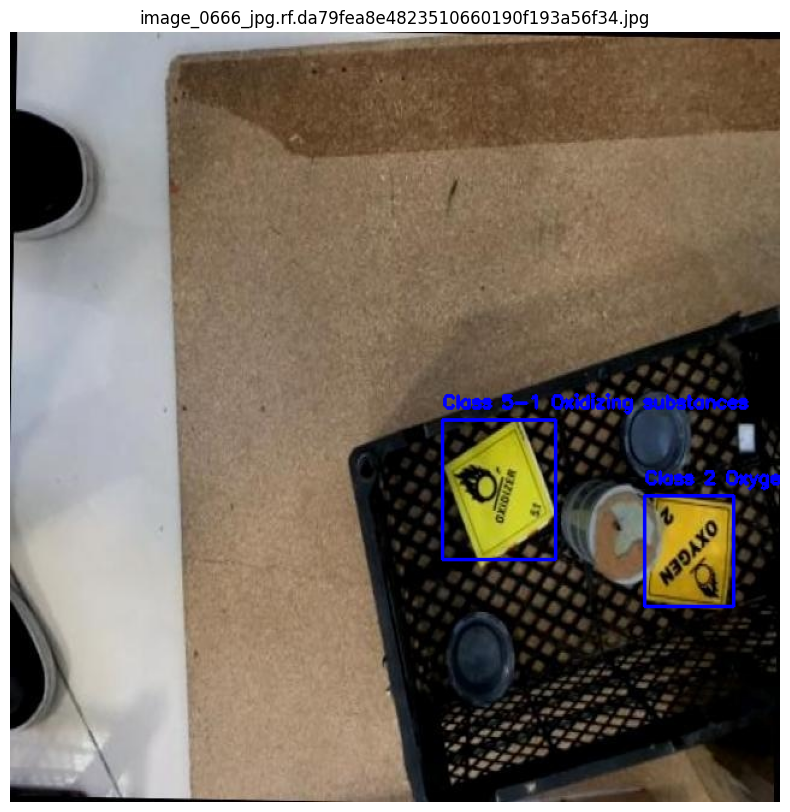

['30', '0.4742063581943512', '0.4076923131942749', '0.8214285969734192', '0.4384615421295166']
Class ID: 30, Class Name: Spontaneously combustible material


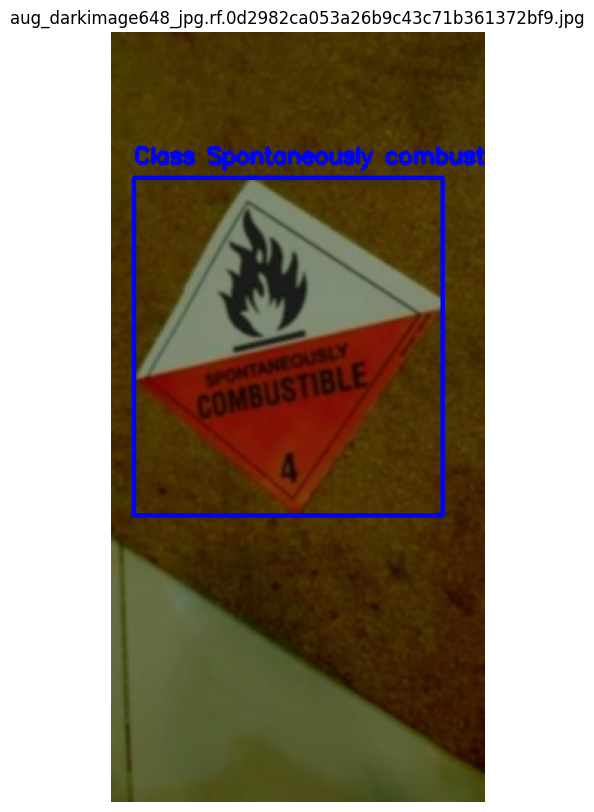

['7', '0.3234375', '0.6515625', '0.11875', '0.109375']
Class ID: 7, Class Name: 2 Oxygen
['18', '0.43046875', '0.46796875', '0.1640625', '0.1296875']
Class ID: 18, Class Name: 5-1 Oxidizing substances
['18', '0.47109375', '0.80703125', '0.1140625', '0.1234375']
Class ID: 18, Class Name: 5-1 Oxidizing substances


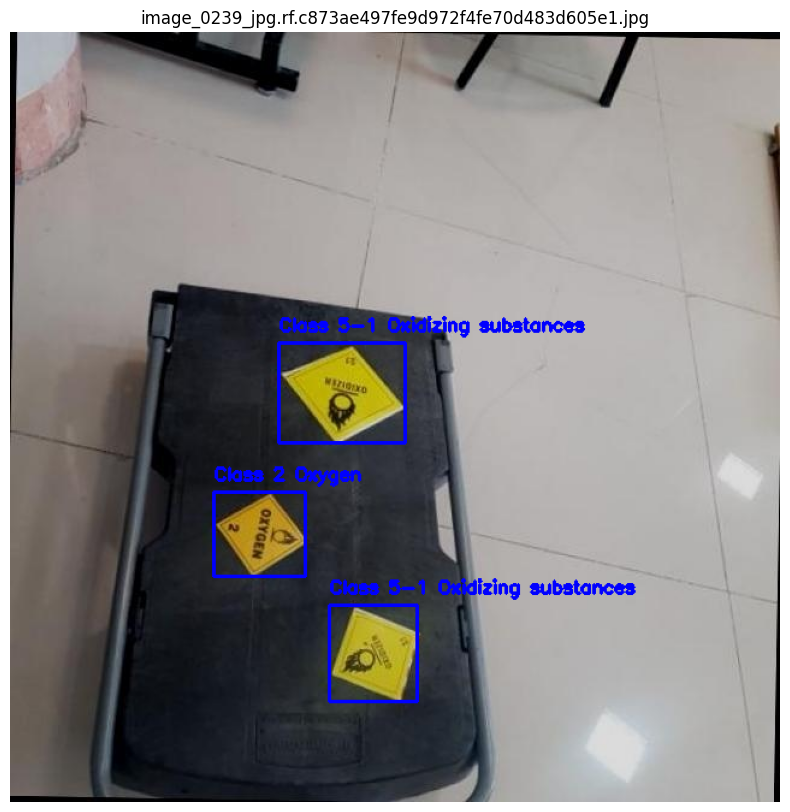

In [5]:
visualize_random_images('data_aug/train/images', 'data_aug/train/labels', class_names=class_names, num_images=5)

Add noise bouding box

In [74]:
def add_noise_to_bboxes(image, bboxes):
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox 

        bbox_region = image[y1:y2, x1:x2]

        noise = np.random.normal(0, 0.5, bbox_region.shape).astype(np.uint8) 
        noisy_bbox_region = cv2.add(bbox_region, noise)

        image[y1:y2, x1:x2] = noisy_bbox_region
    
    return image


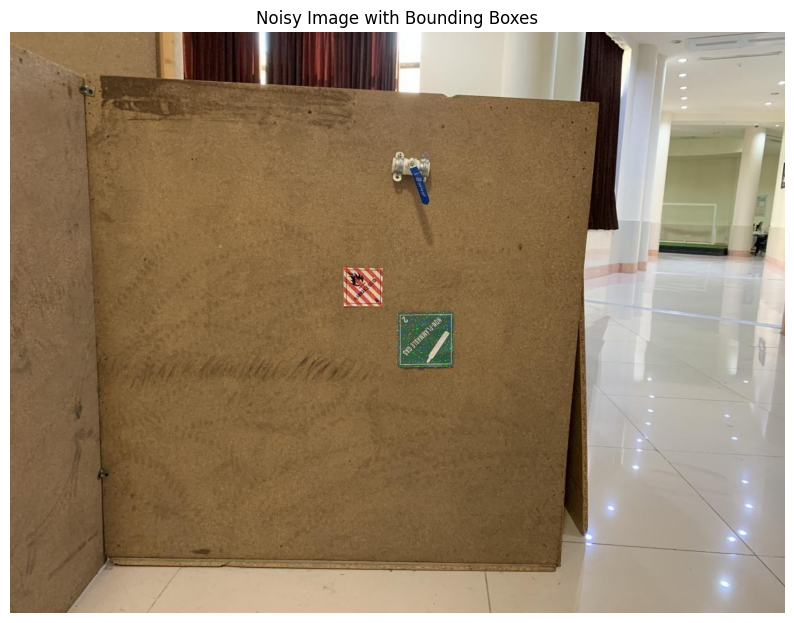

In [75]:
image = cv2.imread('data_aug/train/images/06_jpg.rf.1c5b980cde463430f9068ff8e67e9972.jpg')

bboxes = [
    [0.5359375, 0.5307291666666667, 0.0734375, 0.09895833333333333],
    [0.45546875, 0.4401041666666667, 0.0515625, 0.06770833333333333],
]

img_height, img_width, _ = image.shape
pixel_bboxes = [
    [
        int((x_center - bbox_width / 2) * img_width),
        int((y_center - bbox_height / 2) * img_height),
        int((x_center + bbox_width / 2) * img_width),
        int((y_center + bbox_height / 2) * img_height)
    ]
    for x_center, y_center, bbox_width, bbox_height in bboxes
]

noisy_image = add_noise_to_bboxes(image, pixel_bboxes)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.title('Noisy Image with Bounding Boxes')
plt.show()


augmentation image dark

In [90]:
source_image_folder = 'Hazmat Placards.v1i.yolov11/train/images'
source_label_folder = 'Hazmat Placards.v1i.yolov11/train/labels'
aug_image_folder = 'data_aug/train/images'
aug_label_folder = 'data_aug/train/labels'

os.makedirs(aug_image_folder, exist_ok=True)
os.makedirs(aug_label_folder, exist_ok=True)

def clip_bboxes(bbox, min_value=0, max_value=1):
    return [max(min(coord, max_value), min_value) for coord in bbox]

transform = A.Compose([
        A.RandomBrightnessContrast(brightness_limit=(-0.3, -0.3), contrast_limit=(-0.2, -0.2), p=1), 
        A.GaussianBlur(blur_limit=(3, 7), p=1), 
        A.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=-50, val_shift_limit=-30, p=1),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

for image_filename in os.listdir(source_image_folder):
    if image_filename.endswith('.jpg') or image_filename.endswith('.png'):  
        try:
            image_path = os.path.join(source_image_folder, image_filename)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Unable to read image {image_filename}. Skipping.")
                continue  
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

            label_filename = image_filename.replace('.jpg', '.txt').replace('.png', '.txt')
            label_path = os.path.join(source_label_folder, label_filename)

            bboxes = []
            class_labels = []

            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                values = line.strip().split() 
                class_id, x_center, y_center, bbox_width, bbox_height = map(float, values)

                bboxes.append([x_center, y_center, bbox_width, bbox_height])
                class_labels.append(int(class_id))  

            bboxes = [clip_bboxes(bbox) for bbox in bboxes]

            augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
            augmented_image = augmented['image']
            augmented_bboxes = [clip_bboxes(bbox) for bbox in augmented['bboxes']]
            
            augmented_image_path = os.path.join(aug_image_folder, f'aug_dark{image_filename}')  
            cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

            augmented_label_path = os.path.join(aug_label_folder, f'aug_dark{label_filename}') 
            with open(augmented_label_path, 'w') as f:
                for bbox, class_id in zip(augmented_bboxes, class_labels):
                    f.write(f"{class_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

        except Exception as e:
            print(f"Error processing {image_filename}: {e}. Skipping.")

print("Augmentation completed and images and labels are saved.")


Error processing 35d16e7e67_jpg.rf.81e4449b76197cd1bd678af2fb8de770.jpg: Expected y_max for bbox [0.0000000e+00 1.6700029e-03 1.0000000e+00 1.0000100e+00 2.0000000e+00] to be in the range [0.0, 1.0], got 1.0000100135803223.. Skipping.
Error processing 540b67d94f_jpg.rf.58a911ae03f4daf49bf22b167eb97b15.jpg: Expected y_max for bbox [4.9999952e-03 1.6700029e-03 1.0000000e+00 1.0000100e+00 3.0000000e+00] to be in the range [0.0, 1.0], got 1.0000100135803223.. Skipping.
Error processing Truck185_jpg.rf.8d228959aff7c152dea0e58f83750c50.jpg: too many values to unpack (expected 5). Skipping.
Error processing Truck236_jpg.rf.a3ef0f1bca8edd4635ca2df1b44f3334.jpg: too many values to unpack (expected 5). Skipping.
Error processing Truck238_jpg.rf.16efad0afe281f1bbb31f17ce840708d.jpg: too many values to unpack (expected 5). Skipping.
Error processing Truck243_jpg.rf.fb9ca51a4b1a5a630998dc4c1c4a0f7e.jpg: too many values to unpack (expected 5). Skipping.
Error processing Truck282_jpg.rf.2ada5babe59ec

Augmentation image light

In [91]:
source_image_folder = 'Hazmat Placards.v1i.yolov11/train/images'
source_label_folder = 'Hazmat Placards.v1i.yolov11/train/labels'
aug_image_folder = 'data_aug/train/images'
aug_label_folder = 'data_aug/train/labels'

os.makedirs(aug_image_folder, exist_ok=True)
os.makedirs(aug_label_folder, exist_ok=True)

def clip_bboxes(bbox, min_value=0, max_value=1):
    return [max(min(coord, max_value), min_value) for coord in bbox]

transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(0.4, 0.6), contrast_limit=(0.3, 0.5), p=1), 
    A.GaussianBlur(blur_limit=(3, 7), p=1),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

for image_filename in os.listdir(source_image_folder):
    if image_filename.endswith('.jpg') or image_filename.endswith('.png'):  
        try:
            image_path = os.path.join(source_image_folder, image_filename)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Warning: Unable to read image {image_filename}. Skipping.")
                continue  
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

            label_filename = image_filename.replace('.jpg', '.txt').replace('.png', '.txt')
            label_path = os.path.join(source_label_folder, label_filename)

            bboxes = []
            class_labels = []

            with open(label_path, 'r') as f:
                lines = f.readlines()

            for line in lines:
                values = line.strip().split() 
                class_id, x_center, y_center, bbox_width, bbox_height = map(float, values)

                bboxes.append([x_center, y_center, bbox_width, bbox_height])
                class_labels.append(int(class_id))  

            bboxes = [clip_bboxes(bbox) for bbox in bboxes]

            augmented = transform(image=image, bboxes=bboxes, class_labels=class_labels)
            augmented_image = augmented['image']
            augmented_bboxes = [clip_bboxes(bbox) for bbox in augmented['bboxes']]
            
            augmented_image_path = os.path.join(aug_image_folder, f'aug_light{image_filename}')  
            cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))

            augmented_label_path = os.path.join(aug_label_folder, f'aug_light{label_filename}') 
            with open(augmented_label_path, 'w') as f:
                for bbox, class_id in zip(augmented_bboxes, class_labels):
                    f.write(f"{class_id} {bbox[0]} {bbox[1]} {bbox[2]} {bbox[3]}\n")

        except Exception as e:
            print(f"Error processing {image_filename}: {e}. Skipping.")

print("Augmentation completed and images and labels are saved.")


Error processing 35d16e7e67_jpg.rf.81e4449b76197cd1bd678af2fb8de770.jpg: Expected y_max for bbox [0.0000000e+00 1.6700029e-03 1.0000000e+00 1.0000100e+00 2.0000000e+00] to be in the range [0.0, 1.0], got 1.0000100135803223.. Skipping.
Error processing 540b67d94f_jpg.rf.58a911ae03f4daf49bf22b167eb97b15.jpg: Expected y_max for bbox [4.9999952e-03 1.6700029e-03 1.0000000e+00 1.0000100e+00 3.0000000e+00] to be in the range [0.0, 1.0], got 1.0000100135803223.. Skipping.
Error processing Truck185_jpg.rf.8d228959aff7c152dea0e58f83750c50.jpg: too many values to unpack (expected 5). Skipping.
Error processing Truck236_jpg.rf.a3ef0f1bca8edd4635ca2df1b44f3334.jpg: too many values to unpack (expected 5). Skipping.
Error processing Truck238_jpg.rf.16efad0afe281f1bbb31f17ce840708d.jpg: too many values to unpack (expected 5). Skipping.
Error processing Truck243_jpg.rf.fb9ca51a4b1a5a630998dc4c1c4a0f7e.jpg: too many values to unpack (expected 5). Skipping.
Error processing Truck282_jpg.rf.2ada5babe59ec

augmentation new data